In [26]:
import sys

import numpy as np
from matplotlib import pyplot as plt
import scipy.signal
import torch
import time

sys.path.append('./src')
from msg.msg import MSGNet
from msg.visualization import render_disparity

## Load data

In [27]:
data = {}
samples = 'lucy', 'plant', 'vintage'

for sample in samples:
    data[sample] = {}
    for modality in 'disparity', 'rgb':
        with open(f'data/{sample}_{modality}.npy', 'rb') as file:
            data[sample][modality] = np.load(file)
    with open(f'data/{sample}_calibration.npy', 'rb') as file:
        data[sample]['calibration'] = np.load(file, allow_pickle=True)
       

In [28]:
print(data[samples[1]]['disparity'].shape) 
print(data[samples[1]]['calibration'].shape) 

(512, 512)
()


#### Calculate low resolution images

In [29]:
def box_downsample(ar, factor):
    kernel = np.full((factor, factor), 1 / (factor**2))
    ar = scipy.signal.convolve2d(np.asarray(ar), kernel, mode='full')
    ar = ar[factor-1::factor, factor-1::factor]
    return ar

In [30]:
for sample in samples:
    data[sample]['lr4_disparity'] = box_downsample(data[sample]['disparity'], 4)
    data[sample]['lr8_disparity'] = box_downsample(data[sample]['disparity'], 8)

In [31]:
print(data[samples[1]]['lr4_disparity'].shape) 
print(data[samples[1]]['lr8_disparity'].shape) 

(128, 128)
(64, 64)


#### Visualize data

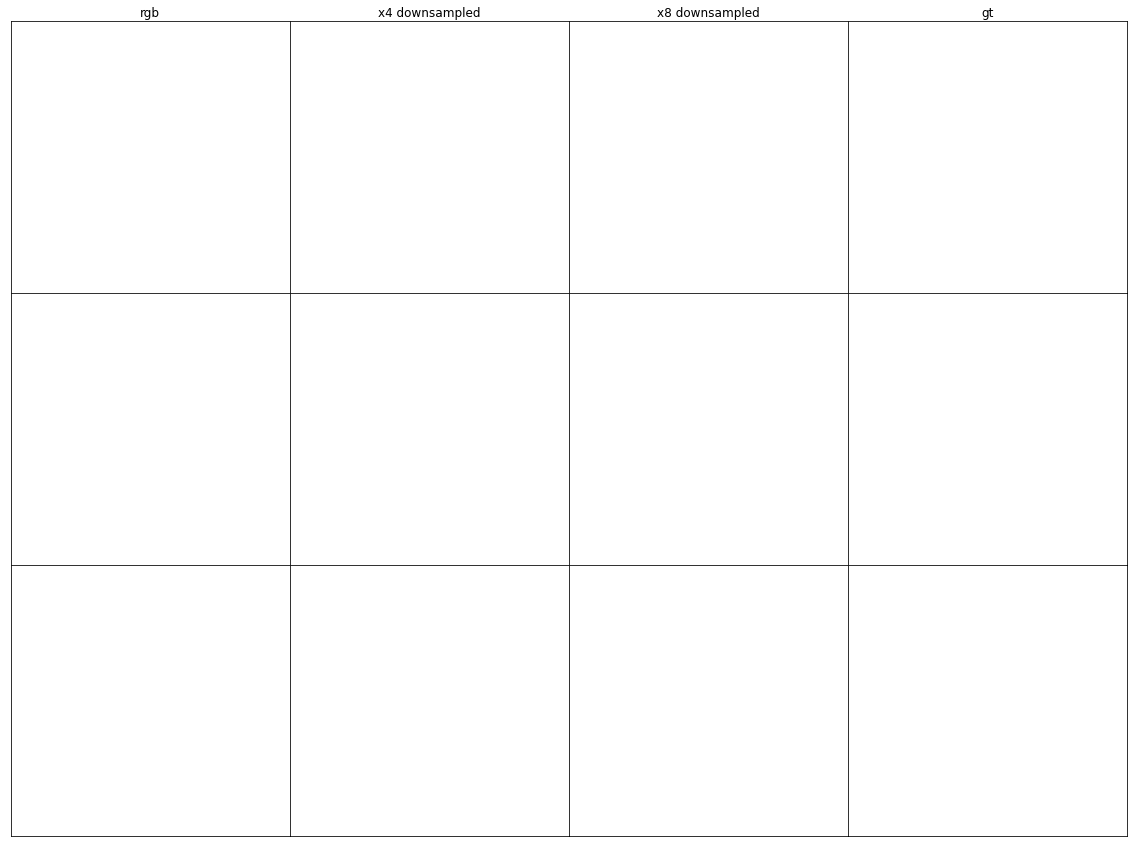

In [32]:
fig, axes = plt.subplots(len(samples), 4, figsize=[5 * 4, 5 * len(samples)])
for axes_ in axes:
    for ax in axes_:
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
labels = ['rgb', 'x4 downsampled', 'x8 downsampled', 'gt']
for i, ax in enumerate(axes[0]):
    ax.xaxis.set_label_position('top')
    ax.set_xlabel(labels[i], fontsize=12)
fig.subplots_adjust(wspace=0, hspace=0)

In [37]:
data[sample]['rgb'].shape

(512, 512, 3)

In [35]:
for sample_i, sample in enumerate(samples):
    axes[sample_i][0].imshow(data[sample]['rgb'])
    axes[sample_i][1].imshow(data[sample]['lr4_disparity'], cmap="Spectral")
    axes[sample_i][2].imshow(data[sample]['lr8_disparity'], cmap='jet')
    axes[sample_i][3].imshow(data[sample]['disparity'], cmap='jet')

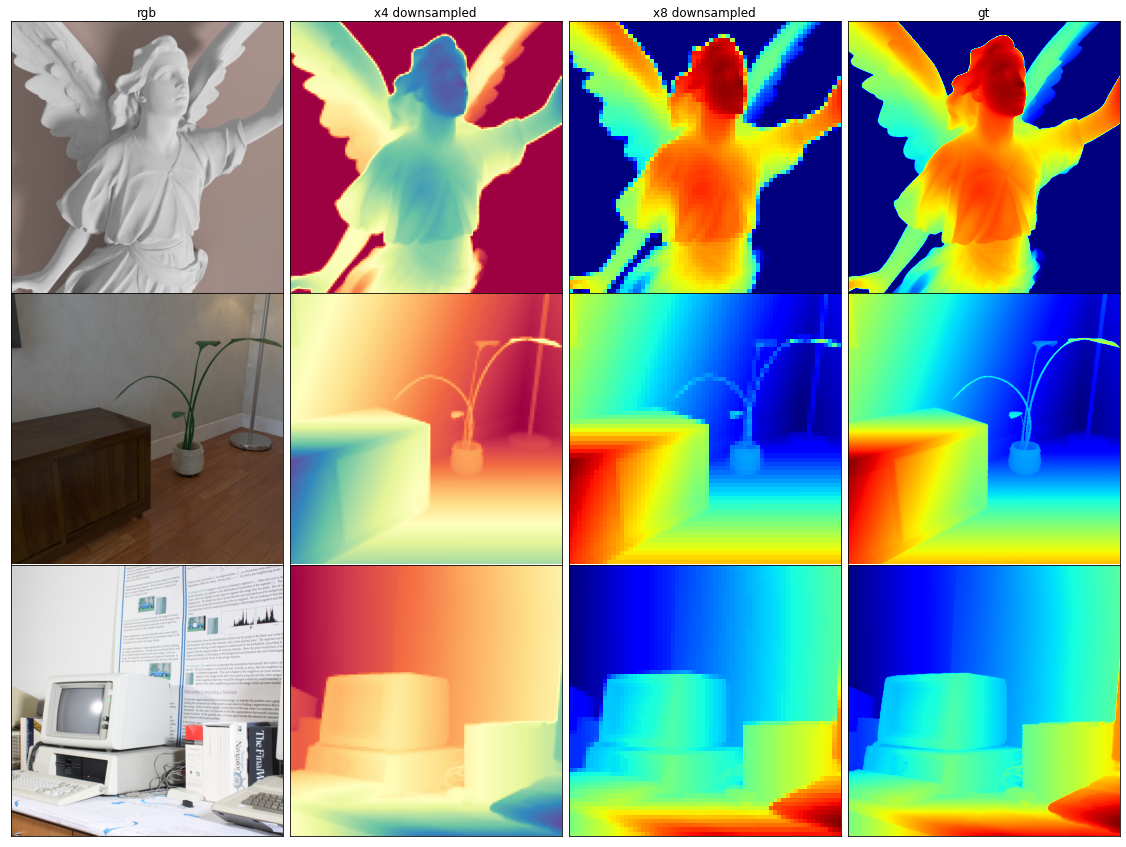

In [36]:
%matplotlib inline
fig

## Test

In [14]:
t = time.time()
model = MSGNet(4)
model.load_state_dict(torch.load('checkpoints/x4_clean.pth')['model_state_dict'])
for sample in data.keys():
    data[sample]['sr4_disparity'] = model.test(data[sample]['lr4_disparity'], data[sample]['rgb'])
elapsed = time.time() - t
print(elapsed)

t = time.time()
model = MSGNet(8)
model.load_state_dict(torch.load('checkpoints/x8_clean.pth')['model_state_dict'])
for sample in data.keys():
    data[sample]['sr8_disparity'] = model.test(data[sample]['lr8_disparity'], data[sample]['rgb'])
elapsed = time.time() - t
print(elapsed)        

10.651640892028809
10.992643117904663


In [38]:
data.keys()

dict_keys(['lucy', 'plant', 'vintage'])

#### Visualize results

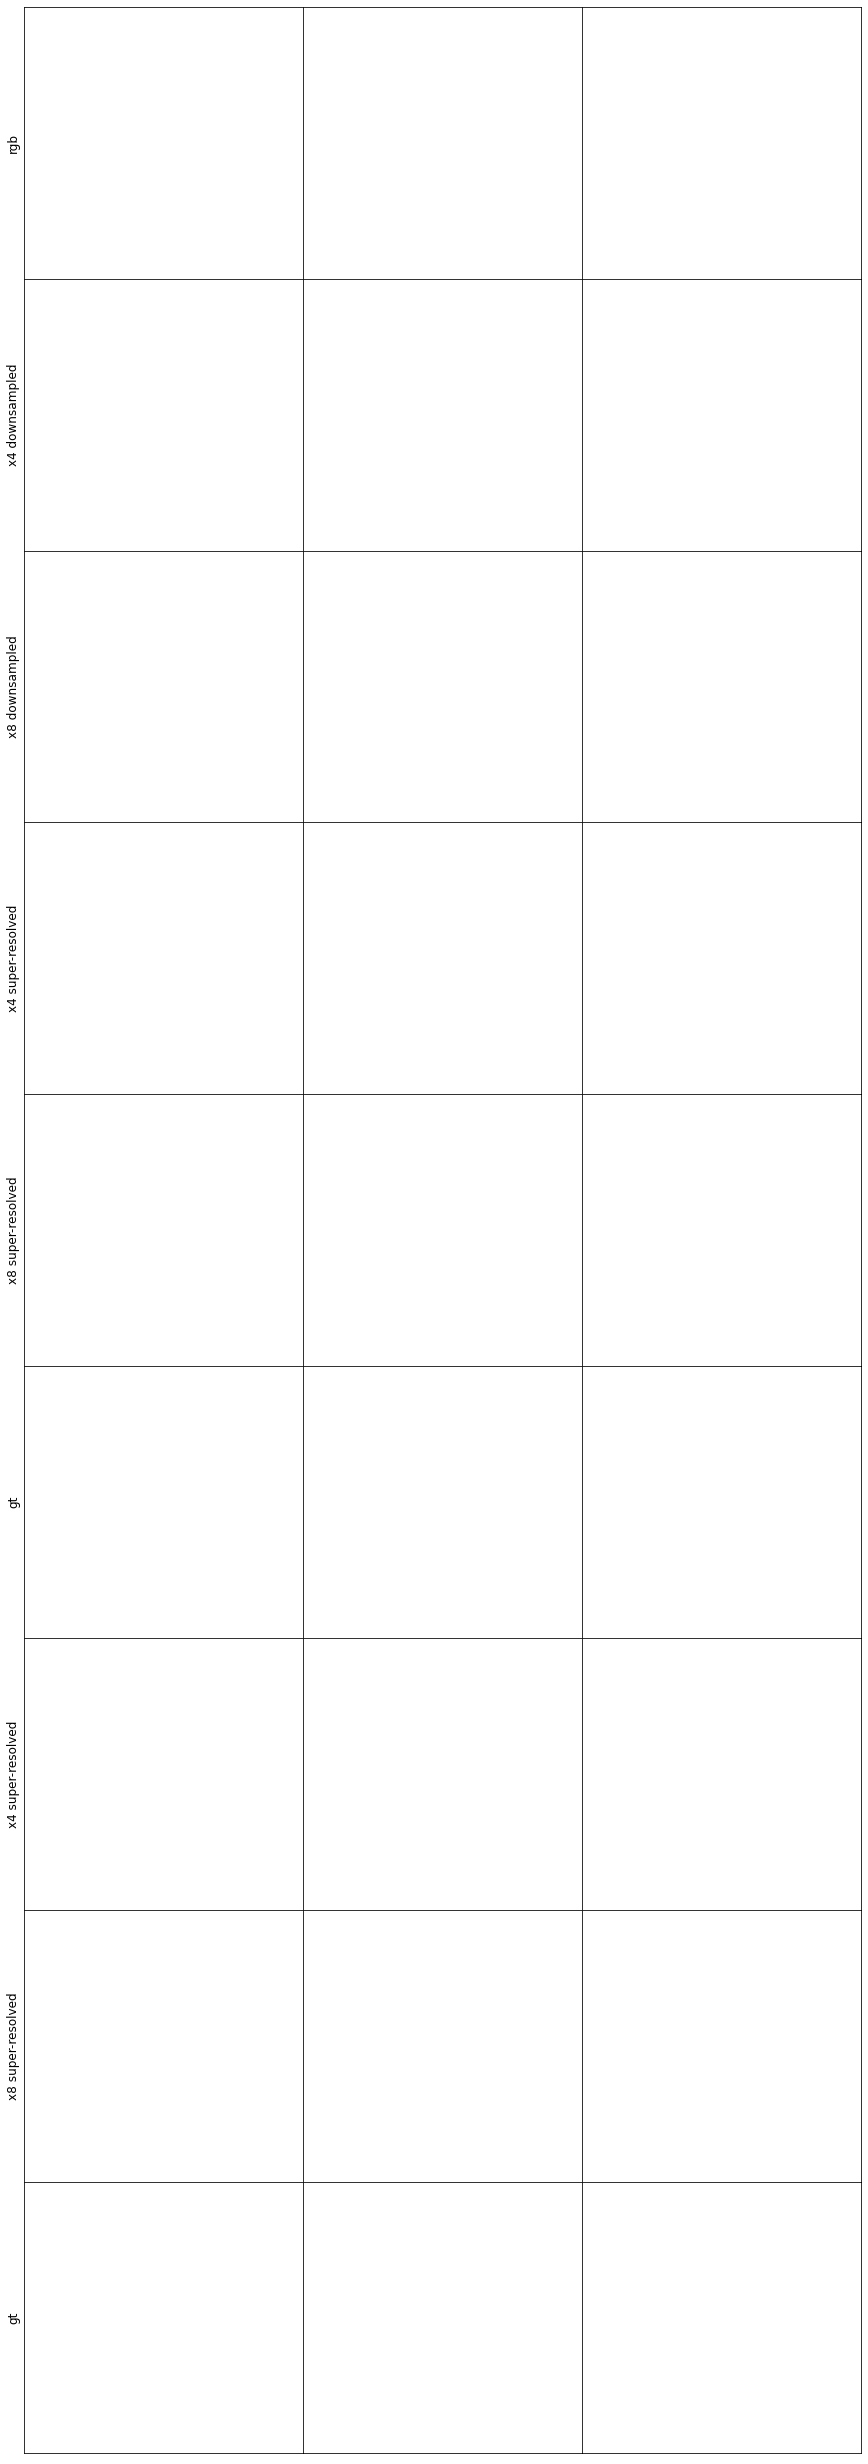

In [15]:
fig, axes = plt.subplots(9, len(samples), figsize=[5 * len(samples), 5 * 9])
for axes_ in axes:
    for ax in axes_:
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
labels = ['rgb', 'x4 downsampled', 'x8 downsampled', 'x4 super-resolved', 'x8 super-resolved', 'gt', 'x4 super-resolved', 'x8 super-resolved', 'gt']
for i, ax in enumerate(axes[:, 0]):
    ax.yaxis.set_label_position('left')
    ax.set_ylabel(labels[i], fontsize=12)
fig.subplots_adjust(wspace=0, hspace=0)

In [16]:
def render_disparity_wrapper(disparity, calibration):
    return render_disparity(disparity, calibration=calibration, light_dir=[0,0,1])

In [17]:
for sample_i, sample in enumerate(samples):
    axes[0][sample_i].imshow(data[sample]['rgb'])
    
    axes[1][sample_i].imshow(data[sample]['lr4_disparity'], cmap='jet')
    axes[2][sample_i].imshow(data[sample]['lr8_disparity'], cmap='jet')
    axes[3][sample_i].imshow(data[sample]['sr4_disparity'], cmap='jet')
    axes[4][sample_i].imshow(data[sample]['sr8_disparity'], cmap='jet')
    axes[5][sample_i].imshow(data[sample]['disparity'], cmap='jet')
    
    axes[6][sample_i].imshow(render_disparity_wrapper(data[sample]['sr4_disparity'], data[sample]['calibration'].item()), cmap='gray')
    axes[7][sample_i].imshow(render_disparity_wrapper(data[sample]['sr8_disparity'], data[sample]['calibration'].item()), cmap='gray')
    axes[8][sample_i].imshow(render_disparity_wrapper(data[sample]['disparity'], data[sample]['calibration'].item()), cmap='gray')

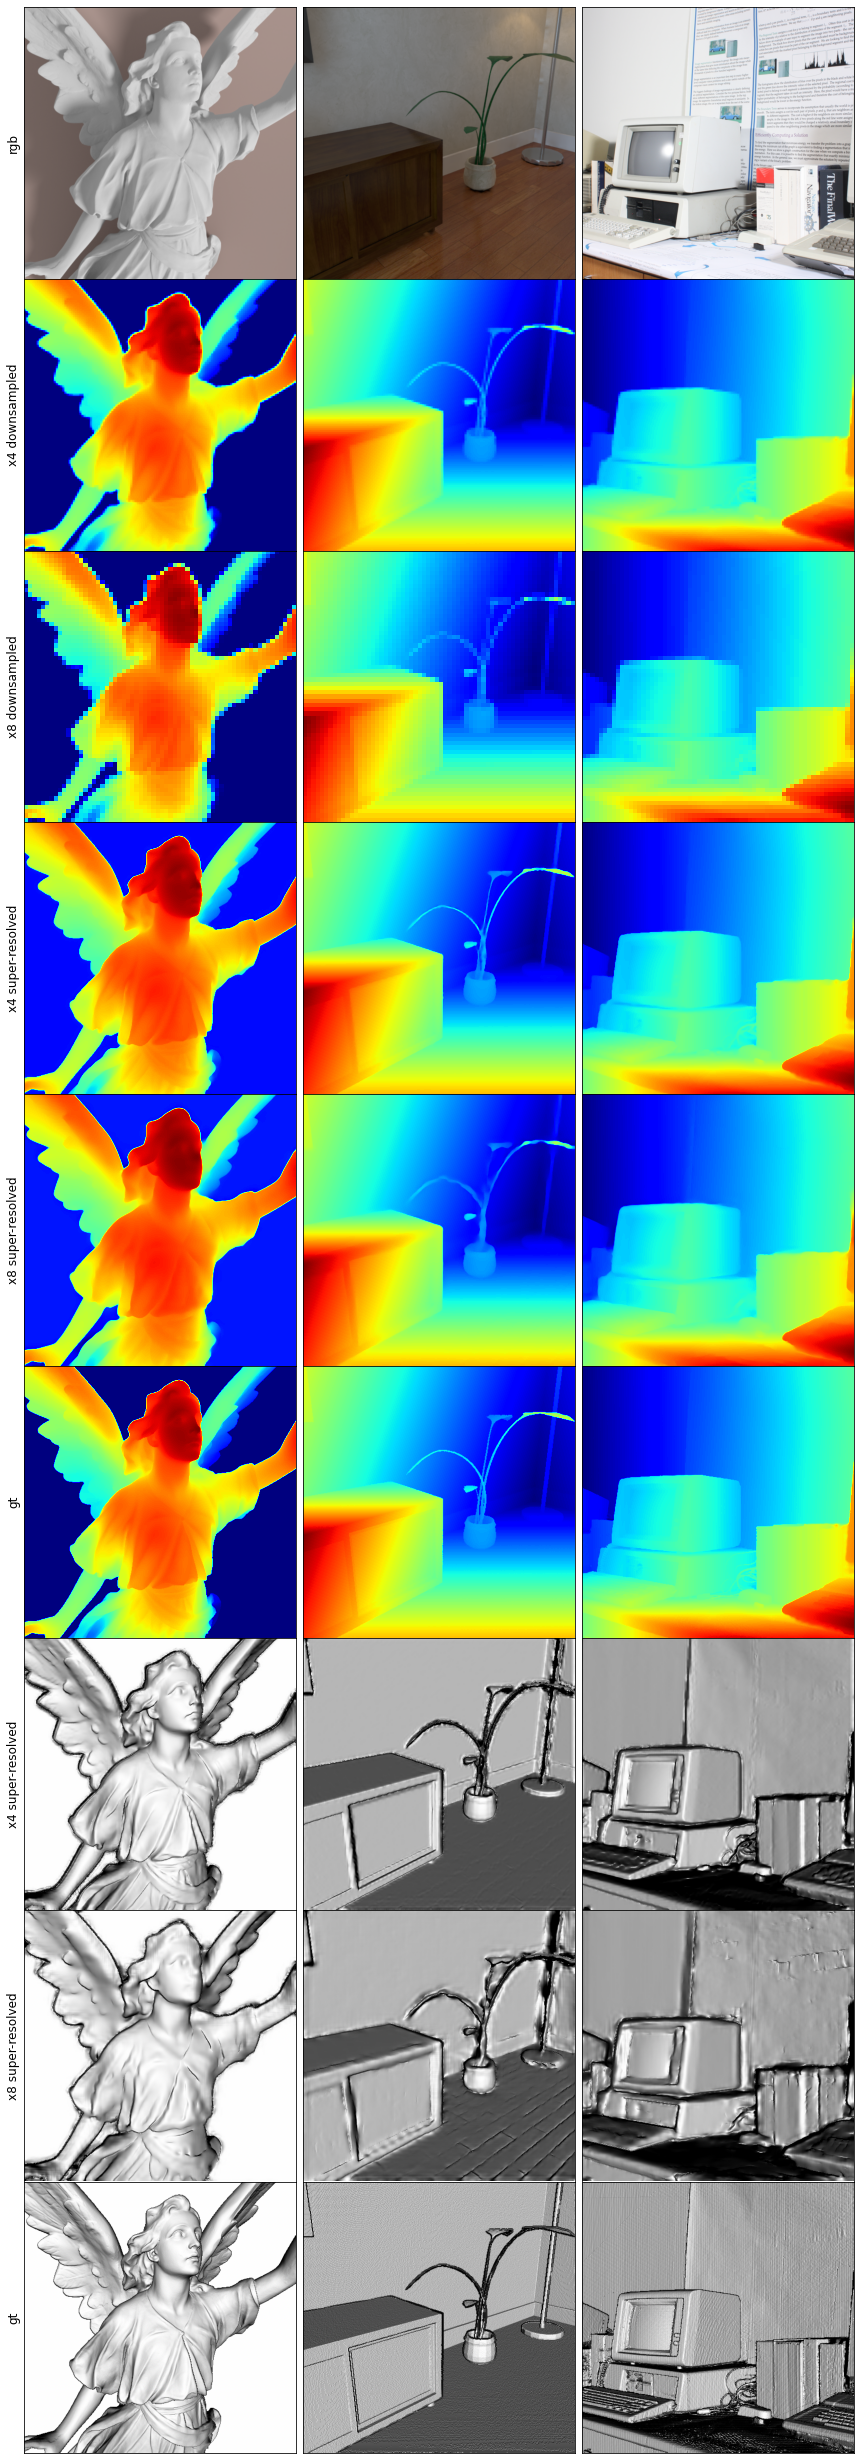

In [18]:
%matplotlib inline
fig

## Test Noisy

In [19]:
data = {}
samples = 'books',

for sample in samples:
    data[sample] = {}
    for modality in 'disparity', 'rgb', 'lr4_disparity':
        with open(f'data/{sample}_{modality}.npy', 'rb') as file:
            data[sample][modality] = np.load(file)
    with open(f'data/{sample}_calibration.npy', 'rb') as file:
        data[sample]['calibration'] = np.load(file, allow_pickle=True)

#### x4 noisy

In [20]:
model = MSGNet(4)
model.load_state_dict(torch.load('checkpoints/x4_noise_std0.003.pth')['model_state_dict'])
for sample in samples:
    data[sample]['sr4_disparity'] = model.test(data[sample]['lr4_disparity'], data[sample]['rgb'])

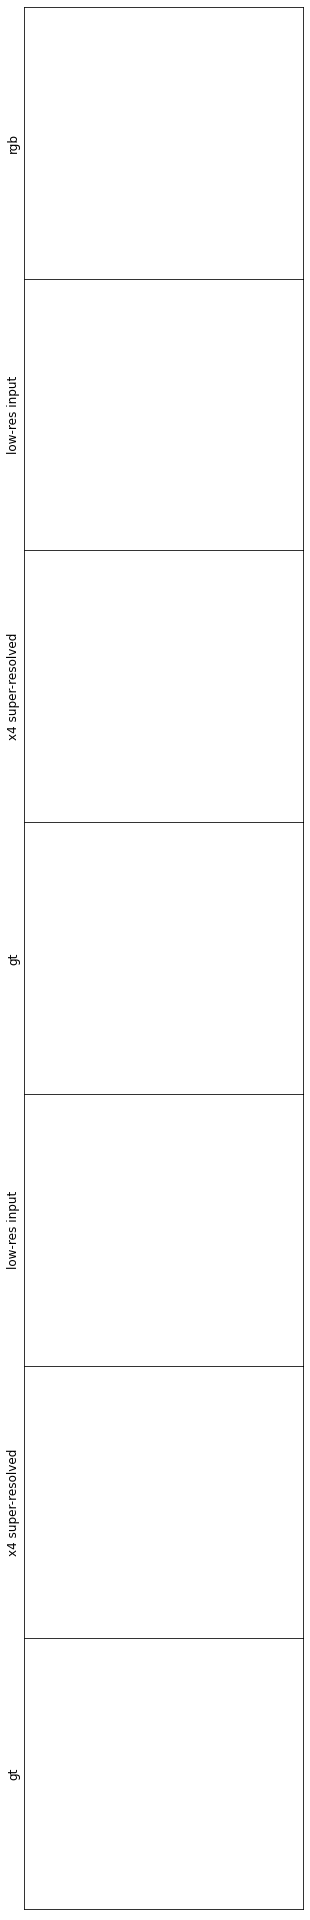

In [21]:
fig, axes = plt.subplots(7, len(samples), figsize=[5 * len(samples), 5 * 7])
if len(samples) == 1:
    axes = axes.reshape(axes.shape[0], 1)

for axes_ in axes:
    for ax in axes_:
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
labels = ['rgb', 'low-res input', 'x4 super-resolved', 'gt', 'low-res input', 'x4 super-resolved', 'gt']
for i, ax in enumerate(axes[:, 0]):
    ax.yaxis.set_label_position('left')
    ax.set_ylabel(labels[i], fontsize=12)
fig.subplots_adjust(wspace=0, hspace=0)

In [22]:
for sample_i, sample in enumerate(samples):
    axes[0][sample_i].imshow(data[sample]['rgb'])
    
    axes[1][sample_i].imshow(data[sample]['lr4_disparity'], cmap='jet')
    axes[2][sample_i].imshow(data[sample]['sr4_disparity'], cmap='jet')
    axes[3][sample_i].imshow(data[sample]['disparity'], cmap='jet')
    
    axes[4][sample_i].imshow(render_disparity_wrapper(data[sample]['lr4_disparity']*4, data[sample]['calibration'].item()), cmap='gray')
    axes[5][sample_i].imshow(render_disparity_wrapper(data[sample]['sr4_disparity']*4, data[sample]['calibration'].item()), cmap='gray')
    axes[6][sample_i].imshow(render_disparity_wrapper(data[sample]['disparity'], data[sample]['calibration'].item()), cmap='gray')

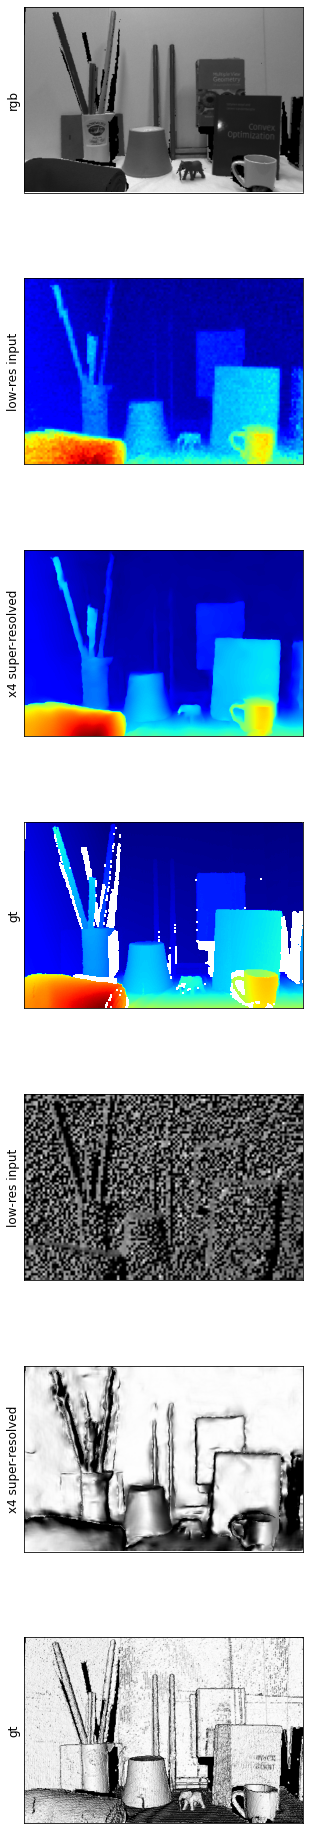

In [23]:
%matplotlib inline
fig